#### С другой функцией вознаграждения

In [ ]:
import json
import math
import random

import gym
import numpy as np
import pandas as pd
import pyglet
import scipy.constants
import scipy.integrate
from gym import spaces
from gym.utils import seeding

MIN_VOLTAGE = 0.0
MAX_VOLTAGE = 24.0

MIN_X = -10.0
MAX_X = -MIN_X

MIN_XI = -1.0
MAX_XI = -MIN_XI

MIN_DX = -10.0
MAX_DX = -MIN_DX
MIN_DXI = MIN_DX
MAX_DXI = -MIN_DX


class CapsubotEnv(gym.Env):
    """A cabsubot with electromagnetic coil"""

    metadata = {"render.modes": ["live", "file", "none", "human"]}
    visualization = None

    def __init__(self):
        super(CapsubotEnv, self).__init__()

        # self.is_right_movement = True
        self.total_time = None
        self.state = None
        self.average_speed = 0
        self.M = 0.193
        self.m = 0.074
        self.stiffness = 256.23
        self.force_max = 1.25
        self.mu = 0.29  # Coefficient of friction.

        self.steps_in_period = 200
        self.min_period = 0.01
        self.dt = self.min_period / self.steps_in_period  # Action force discritization.
        self.frame_skip = 40
        self.previous_reward = 0.0
        self.done = False

        self.action_space = spaces.Discrete(2)

        self.observation_space = spaces.Box(
            low=np.array([MIN_X, MIN_DX, MIN_XI, MIN_DXI]),
            high=np.array([MAX_X, MAX_DX, MAX_XI, MAX_DXI]),
            dtype=np.float32,
        )

        self.viewer = None
        self.seed()

    def seed(self, seed=42):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def F_step(self, action):
        return action * self.force_max

    def friction_model(self, velocity):
        N = (self.M + self.m) * scipy.constants.g
        return -N * 2 / np.pi * np.arctan(velocity * 10e5)
        # return -np.sign(velocity) * N * self.mu

    def mechanical_model(self, y, t, force):
        x, x_dot, xi, xi_dot = y
        friction = self.friction_model(x_dot)
        x_acc = (self.stiffness * xi - force + friction) / self.M
        xi_acc = (-self.stiffness * xi + force) / self.m - x_acc
        return [x_dot, x_acc, xi_dot, xi_acc]

    def step(self, action, integrator="euler"):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg

        for _ in range(self.frame_skip):
            x, x_dot, xi, xi_dot = self.state

            self.force = self.F_step(action)

            # Euler kinematic integration.
            dx = self.mechanical_model(self.state, 0, self.force)
            self.state = [
                x + self.dt * dx[0],
                x_dot + self.dt * dx[1],
                xi + self.dt * dx[2],
                xi_dot + self.dt * dx[3],
            ]

            self.total_time = self.total_time + self.dt
            self.average_speed = x / self.total_time

        step_reward = 0
        if self.average_speed > 0.0:
            reward = self.average_speed * 1000
            step_reward = reward - self.previous_reward
            self.previous_reward = reward
        if x >= 0.05:
            self.done = True    # Спросить про вот этот момент
            step_reward += 500
        elif x <= -0.007:
            self.done = True
            step_reward -= 1000

        return np.array(self.state), step_reward, self.done, {"average_speed": self.average_speed}

    def reset(self):
        self.state = (0, 0, 0, 0)
        self.total_time = 0.0
        self.average_speed = 0.0
        self.previous_reward = 0.0
        self.done = False
        return np.array(self.state).astype(np.float32)

    def render(self, mode="human"):
        screen_width = 1280
        screen_height = 400

        capsule_length = 100.0
        capsule_height = 30.0

        world_width = 1.0
        scale = screen_width / world_width

        inner_body_length = capsule_length / 2.0
        inner_body_height = capsule_height
        inner_body_y = capsule_height

        ground_level = 200

        if self.viewer is None:
            from gym.envs.classic_control import rendering

            self.viewer = rendering.Viewer(screen_width, screen_height)
            # Capsule polygon.
            l, r, t, b = (
                -capsule_length / 2,
                capsule_length / 2,
                capsule_height / 2,
                -capsule_height / 2,
            )
            capsule = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.capsule_transform = rendering.Transform()
            capsule.add_attr(self.capsule_transform)
            self.viewer.add_geom(capsule)

            # Inner body polygon
            l, r, t, b = (
                -inner_body_length / 2,
                inner_body_length / 2,
                inner_body_height / 2,
                -inner_body_height / 2,
            )
            inner_body = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.inner_body_transform = rendering.Transform()
            inner_body.add_attr(self.inner_body_transform)
            inner_body.add_attr(self.capsule_transform)
            inner_body.set_color(0.8, 0.6, 0.4)
            self.viewer.add_geom(inner_body)

            # Ground surface
            self.track = rendering.Line((0, ground_level), (screen_width, ground_level))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            # Score
            self.score_label = pyglet.text.Label(
                "0000",
                font_size=36,
                x=20,
                y=screen_width * 2.5 / 40.00,
                anchor_x="left",
                anchor_y="center",
                color=(255, 255, 255, 255),
            )

        if self.state is None:
            return None

        x, x_dot, xi, xi_dot = self.state
        capsule_x = x * scale + screen_width / 2.0  # MIDDLE OF CART
        capsule_y = ground_level + capsule_height / 2.0  # MIDDLE OF CART
        self.capsule_transform.set_translation(capsule_x, capsule_y)

        inner_body_x = xi * scale  # MIDDLE OF CART
        self.inner_body_transform.set_translation(inner_body_x, inner_body_y)

        self.score_label.text = "%04i" % self.average_speed
        self.score_label.draw()

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None


### Test version

In [7]:
import gym
import numpy as np
import pyglet
import scipy.constants
import scipy.integrate
from gym import spaces
from gym.utils import seeding

MIN_VOLTAGE = 0.0
MAX_VOLTAGE = 24.0

MIN_X = -10.0
MAX_X = -MIN_X

MIN_XI = -1.0
MAX_XI = -MIN_XI

MIN_DX = -10.0
MAX_DX = -MIN_DX
MIN_DXI = MIN_DX
MAX_DXI = -MIN_DX


class CapsubotEnv(gym.Env):
    """A cabsubot with electromagnetic coil"""

    metadata = {"render.modes": ["live", "file", "none", "human"]}
    visualization = None

    def __init__(self):
        super(CapsubotEnv, self).__init__()

        self.total_time = None
        self.state = None
        self.average_speed = 0
        self.M = 0.193
        self.m = 0.074
        self.stiffness = 256.23
        self.force_max = 1.25
        self.mu = 0.29  # Coefficient of friction.
        self.step_counter = 0

        self.steps_in_period = 200
        self.min_period = 0.01
        self.dt = self.min_period / self.steps_in_period  # Action force discritization.
        self.frame_skip = int(self.steps_in_period)
        self.previous_average_speed = 0.0
        self.done = False

        self.action_space = spaces.Discrete(2)

        self.observation_space = spaces.Box(
            low=np.array([MIN_X, MIN_DX, MIN_XI, MIN_DXI]),
            high=np.array([MAX_X, MAX_DX, MAX_XI, MAX_DXI]),
            dtype=np.float32,
        )

        self.viewer = None
        self.seed()

    def seed(self, seed=42):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def normalize_state(self, state: list) -> np.ndarray:
        state = np.array(state)
        norm_state = []
        norm_state.append(np.interp(state[0], [-0.0007666844383611218, 0.07919885629789096], [-1, 1]))
        norm_state.append(np.interp(state[1], [-0.18283166534706963, 0.24274101317295704], [-1, 1]))
        norm_state.append(np.interp(state[2], [-0.01652187660136813, 0.019895362341591866], [-1, 1]))
        norm_state.append(np.interp(state[3], [-1.1832780931204638, 1.1508305412787394], [-1, 1]))
        return np.array(norm_state)

    def F_step(self, action):
        return action * self.force_max

    def friction_model(self, velocity):
        N = (self.M + self.m) * scipy.constants.g
        return -N * 2 / np.pi * np.arctan(velocity * 10e5)
        # return -np.sign(velocity) * N * self.mu

    def mechanical_model(self, y, t, force):
        x, x_dot, xi, xi_dot = y
        friction = self.friction_model(x_dot)
        x_acc = (self.stiffness * xi - force + friction) / self.M
        xi_acc = (-self.stiffness * xi + force) / self.m - x_acc
        return [x_dot, x_acc, xi_dot, xi_acc]
    
    def calc_reward(self, av_speed, prev_av_speed, scale_factor=1000) -> float:
        return (av_speed  - prev_av_speed) * scale_factor
            
    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg
        self.step_counter += 1

        for _ in range(self.frame_skip):
            x, x_dot, xi, xi_dot = self.state
            
            force = self.F_step(action)

            # Euler kinematic integration.
            dx = self.mechanical_model(self.state, 0, force)
            self.state = [
                x + self.dt * dx[0],
                x_dot + self.dt * dx[1],
                xi + self.dt * dx[2],
                xi_dot + self.dt * dx[3],
            ]

            self.total_time = self.total_time + self.dt
            self.average_speed = x / self.total_time
        
        step_reward = self.calc_reward(self.average_speed, self.previous_average_speed)
        norm_state = self.normalize_state(self.state)
        # TO DO: normalize reward
        self.previous_average_speed = self.average_speed
        
        if x >= 0.3:
            self.done = True  
            step_reward += 500
        elif x <= -0.007:
            self.done = True
            step_reward -= 1000

        return (
            norm_state,
            step_reward,
            self.done,
            {"average_speed": self.average_speed},
        )

    def reset(self):
        self.state = (0, 0, 0, 0)
        self.total_time = 0.0
        self.average_speed = 0.0
        self.previous_average_speed = 0.0
        self.done = False
        self.step_counter = 0
        return np.array(self.state).astype(np.float32)

    def render(self, mode="human"):
        screen_width = 1280
        screen_height = 400

        capsule_length = 100.0
        capsule_height = 30.0

        world_width = 1.0
        scale = screen_width / world_width

        inner_body_length = capsule_length / 2.0
        inner_body_height = capsule_height
        inner_body_y = capsule_height

        ground_level = 200

        if self.viewer is None:
            from gym.envs.classic_control import rendering

            self.viewer = rendering.Viewer(screen_width, screen_height)
            # Capsule polygon.
            l, r, t, b = (
                -capsule_length / 2,
                capsule_length / 2,
                capsule_height / 2,
                -capsule_height / 2,
            )
            capsule = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.capsule_transform = rendering.Transform()
            capsule.add_attr(self.capsule_transform)
            self.viewer.add_geom(capsule)

            # Inner body polygon
            l, r, t, b = (
                -inner_body_length / 2,
                inner_body_length / 2,
                inner_body_height / 2,
                -inner_body_height / 2,
            )
            inner_body = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.inner_body_transform = rendering.Transform()
            inner_body.add_attr(self.inner_body_transform)
            inner_body.add_attr(self.capsule_transform)
            inner_body.set_color(0.8, 0.6, 0.4)
            self.viewer.add_geom(inner_body)

            # Ground surface
            self.track = rendering.Line((0, ground_level), (screen_width, ground_level))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            # Score
            self.score_label = pyglet.text.Label(
                "0000",
                font_size=36,
                x=20,
                y=screen_width * 2.5 / 40.00,
                anchor_x="left",
                anchor_y="center",
                color=(255, 255, 255, 255),
            )

        if self.state is None:
            return None

        x, x_dot, xi, xi_dot = self.state
        capsule_x = x * scale + screen_width / 2.0  # MIDDLE OF CART
        capsule_y = ground_level + capsule_height / 2.0  # MIDDLE OF CART
        self.capsule_transform.set_translation(capsule_x, capsule_y)

        inner_body_x = xi * scale  # MIDDLE OF CART
        self.inner_body_transform.set_translation(inner_body_x, inner_body_y)

        self.score_label.text = "%04i" % self.average_speed
        self.score_label.draw()

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None


In [1]:
import gym
import numpy as np
import pyglet
import scipy.constants
import scipy.integrate
from gym import spaces
from gym.utils import seeding

MIN_VOLTAGE = 0.0
MAX_VOLTAGE = 24.0

MIN_X = -10.0
MAX_X = -MIN_X

MIN_XI = -1.0
MAX_XI = -MIN_XI

MIN_DX = -10.0
MAX_DX = -MIN_DX
MIN_DXI = MIN_DX
MAX_DXI = -MIN_DX


class CapsubotEnv(gym.Env):
    """A cabsubot with electromagnetic coil"""

    metadata = {"render.modes": ["live", "file", "none", "human"]}
    visualization = None

    def __init__(self):
        super(CapsubotEnv, self).__init__()

        self.total_time = None
        self.state = None
        self.M = 0.193
        self.m = 0.074
        self.stiffness = 256.23
        self.force_max = 1.25
        self.mu = 0.29  # Coefficient of friction.

        self.steps_in_period = 200
        self.min_period = 0.01
        self.dt = self.min_period / self.steps_in_period  # Action force discritization.
        self.frame_skip = 40
        self.previous_average_speed = 0.0
        self.done = False

        self.action_space = spaces.Discrete(2)

        self.observation_space = spaces.Box(
            low=np.array([MIN_X, MIN_DX, MIN_XI, MIN_DXI]),
            high=np.array([MAX_X, MAX_DX, MAX_XI, MAX_DXI]),
            dtype=np.float32,
        )

        self.viewer = None
        self.seed()

    def seed(self, seed=42):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def normalize_state(self, state: list) -> np.ndarray:
        """
        Normalizing reward states because NN inside RL agent works better with normalized inputs.
        Because we can't know the true thresholds of the model states, we use that wierd interpolation.
        Thresholds were obtained experimetally.
        """
        state = np.array(state)
        norm_state = []
        norm_state.append(np.interp(state[0], [-0.0007666844383611218, 0.07919885629789096], [-1, 1]))
        norm_state.append(np.interp(state[1], [-0.18283166534706963, 0.24274101317295704], [-1, 1]))
        norm_state.append(np.interp(state[2], [-0.01652187660136813, 0.019895362341591866], [-1, 1]))
        norm_state.append(np.interp(state[3], [-1.1832780931204638, 1.1508305412787394], [-1, 1]))
        return np.array(norm_state)

    def F_step(self, action):
        return action * self.force_max

    def friction_model(self, velocity):
        N = (self.M + self.m) * scipy.constants.g
        return -N * 2 / np.pi * np.arctan(velocity * 10e5)
        # return -np.sign(velocity) * N * self.mu

    def mechanical_model(self, y, t, force):
        x, x_dot, xi, xi_dot = y
        friction = self.friction_model(x_dot)
        x_acc = (self.stiffness * xi - force + friction) / self.M
        xi_acc = (-self.stiffness * xi + force) / self.m - x_acc
        return [x_dot, x_acc, xi_dot, xi_acc]
    
    def calc_reward(self, av_speed, prev_av_speed, scale_factor=1000) -> float:
        return (av_speed  - prev_av_speed) * scale_factor
            
    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg

        for _ in range(self.frame_skip):
            x, x_dot, xi, xi_dot = self.state
            
            force = self.F_step(action)

            # Euler kinematic integration.
            dx = self.mechanical_model(self.state, 0, force)
            self.state = [
                x + self.dt * dx[0],
                x_dot + self.dt * dx[1],
                xi + self.dt * dx[2],
                xi_dot + self.dt * dx[3],
            ]

            self.total_time = self.total_time + self.dt
            average_speed = x / self.total_time
        
        step_reward = self.calc_reward(average_speed, self.previous_average_speed)
        # TO DO: normalize reward
        self.previous_average_speed = average_speed
        norm_state = self.normalize_state(self.state)
        
        if x >= 0.05:
            self.done = True  
            step_reward += 500
        elif x <= -0.007:
            self.done = True
            step_reward -= 1000

        return (
            norm_state,
            step_reward,
            self.done,
            {"average_speed": average_speed},
        )

    def reset(self):
        self.state = (0, 0, 0, 0)
        self.total_time = 0.0
        self.previous_average_speed = 0.0
        self.done = False
        return np.array(self.state).astype(np.float32)

    def render(self, mode="human"):
        screen_width = 1280
        screen_height = 400

        capsule_length = 100.0
        capsule_height = 30.0

        world_width = 1.0
        scale = screen_width / world_width

        inner_body_length = capsule_length / 2.0
        inner_body_height = capsule_height
        inner_body_y = capsule_height

        ground_level = 200

        if self.viewer is None:
            from gym.envs.classic_control import rendering

            self.viewer = rendering.Viewer(screen_width, screen_height)
            # Capsule polygon.
            l, r, t, b = (
                -capsule_length / 2,
                capsule_length / 2,
                capsule_height / 2,
                -capsule_height / 2,
            )
            capsule = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.capsule_transform = rendering.Transform()
            capsule.add_attr(self.capsule_transform)
            self.viewer.add_geom(capsule)

            # Inner body polygon
            l, r, t, b = (
                -inner_body_length / 2,
                inner_body_length / 2,
                inner_body_height / 2,
                -inner_body_height / 2,
            )
            inner_body = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.inner_body_transform = rendering.Transform()
            inner_body.add_attr(self.inner_body_transform)
            inner_body.add_attr(self.capsule_transform)
            inner_body.set_color(0.8, 0.6, 0.4)
            self.viewer.add_geom(inner_body)

            # Ground surface
            self.track = rendering.Line((0, ground_level), (screen_width, ground_level))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            # Score
            self.score_label = pyglet.text.Label(
                "0000",
                font_size=36,
                x=20,
                y=screen_width * 2.5 / 40.00,
                anchor_x="left",
                anchor_y="center",
                color=(255, 255, 255, 255),
            )

        if self.state is None:
            return None

        x, x_dot, xi, xi_dot = self.state
        capsule_x = x * scale + screen_width / 2.0  # MIDDLE OF CART
        capsule_y = ground_level + capsule_height / 2.0  # MIDDLE OF CART
        self.capsule_transform.set_translation(capsule_x, capsule_y)

        inner_body_x = xi * scale  # MIDDLE OF CART
        self.inner_body_transform.set_translation(inner_body_x, inner_body_y)

        #self.score_label.text = "%04i" % self.average_speed
        #self.score_label.draw()

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None


In [1]:
import gym
import numpy as np
import pyglet
import scipy.constants
import scipy.integrate
from gym import spaces
from gym.utils import seeding

MIN_VOLTAGE = 0.0
MAX_VOLTAGE = 24.0

MIN_X = -10.0
MAX_X = -MIN_X

MIN_XI = -1.0
MAX_XI = -MIN_XI

MIN_DX = -10.0
MAX_DX = -MIN_DX
MIN_DXI = MIN_DX
MAX_DXI = -MIN_DX


class CapsubotEnv(gym.Env):
    """A cabsubot with electromagnetic coil"""

    metadata = {"render.modes": ["live", "file", "none", "human"]}
    visualization = None

    def __init__(self):
        super(CapsubotEnv, self).__init__()

        self.total_time = None
        self.state = None
        self.average_speed = 0
        self.M = 0.193
        self.m = 0.074
        self.stiffness = 256.23
        self.force_max = 1.25
        self.mu = 0.29  # Coefficient of friction.

        self.steps_in_period = 200
        self.min_period = 0.01
        self.dt = self.min_period / self.steps_in_period  # Action force discritization.
        self.frame_skip = 40 # TODO: frameskip like fraction of min_period or smth
        self.previous_average_speed = 0.0
        self.done = False

        self.action_space = spaces.Discrete(2)

        self.observation_space = spaces.Box(
            low=np.array([MIN_X, MIN_DX, MIN_XI, MIN_DXI]),
            high=np.array([MAX_X, MAX_DX, MAX_XI, MAX_DXI]),
            dtype=np.float32,
        )

        self.viewer = None
        self.seed()

    def seed(self, seed=42):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def normalize_state(self, state: list) -> np.ndarray:
        """
        Normalizing reward states because NN inside RL agent works better with normalized inputs.
        Because we can't know the true thresholds of the model states, we use that wierd interpolation.
        Thresholds were obtained experimetally.
        """
        state = np.array(state)
        norm_state = []
        norm_state.append(np.interp(state[0], [-0.0007666844383611218, 0.07919885629789096], [-1, 1]))
        norm_state.append(np.interp(state[1], [-0.18283166534706963, 0.24274101317295704], [-1, 1]))
        norm_state.append(np.interp(state[2], [-0.01652187660136813, 0.019895362341591866], [-1, 1]))
        norm_state.append(np.interp(state[3], [-1.1832780931204638, 1.1508305412787394], [-1, 1]))
        return np.array(norm_state)

    def F_step(self, action):
        return action * self.force_max

    def friction_model(self, velocity):
        N = (self.M + self.m) * scipy.constants.g
        return -N * 2 / np.pi * np.arctan(velocity * 10e5)
        # return -np.sign(velocity) * N * self.mu

    def mechanical_model(self, y, t, force):
        x, x_dot, xi, xi_dot = y
        friction = self.friction_model(x_dot)
        x_acc = (self.stiffness * xi - force + friction) / self.M
        xi_acc = (-self.stiffness * xi + force) / self.m - x_acc
        return [x_dot, x_acc, xi_dot, xi_acc]
    
    def calc_reward(self, av_speed, prev_av_speed, scale_factor=1000) -> float:
        return (av_speed - prev_av_speed) * scale_factor
            
    def step(self, action, integrator="euler"):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg

        for _ in range(self.frame_skip):
            x, x_dot, xi, xi_dot = self.state
            
            force = self.F_step(action)

            # Euler kinematic integration.
            dx = self.mechanical_model(self.state, 0, force)
            self.state = [
                x + self.dt * dx[0],
                x_dot + self.dt * dx[1],
                xi + self.dt * dx[2],
                xi_dot + self.dt * dx[3],
            ]

            self.total_time = self.total_time + self.dt
            self.average_speed = x / self.total_time
 
        norm_state = self.normalize_state(self.state)
        # TO DO: normalize reward
        step_reward = self.calc_reward(self.average_speed, self.previous_average_speed)
        self.previous_average_speed = self.average_speed
        
        if x >= 0.05:
            self.done = True  
            step_reward += 500
        elif x <= -0.007:
            self.done = True
            step_reward -= 1000

        return (
            norm_state,
            step_reward,
            self.done,
            {"average_speed": self.average_speed},
        )

    def reset(self):
        self.state = (0, 0, 0, 0)
        self.total_time = 0.0
        self.average_speed = 0.0
        self.previous_average_speed = 0.0
        self.done = False
        return np.array(self.state).astype(np.float32)

    def render(self, mode="human"):
        screen_width = 1280
        screen_height = 400

        capsule_length = 100.0
        capsule_height = 30.0

        world_width = 1.0
        scale = screen_width / world_width

        inner_body_length = capsule_length / 2.0
        inner_body_height = capsule_height
        inner_body_y = capsule_height

        ground_level = 200

        if self.viewer is None:
            from gym.envs.classic_control import rendering

            self.viewer = rendering.Viewer(screen_width, screen_height)
            # Capsule polygon.
            l, r, t, b = (
                -capsule_length / 2,
                capsule_length / 2,
                capsule_height / 2,
                -capsule_height / 2,
            )
            capsule = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.capsule_transform = rendering.Transform()
            capsule.add_attr(self.capsule_transform)
            self.viewer.add_geom(capsule)

            # Inner body polygon
            l, r, t, b = (
                -inner_body_length / 2,
                inner_body_length / 2,
                inner_body_height / 2,
                -inner_body_height / 2,
            )
            inner_body = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.inner_body_transform = rendering.Transform()
            inner_body.add_attr(self.inner_body_transform)
            inner_body.add_attr(self.capsule_transform)
            inner_body.set_color(0.8, 0.6, 0.4)
            self.viewer.add_geom(inner_body)

            # Ground surface
            self.track = rendering.Line((0, ground_level), (screen_width, ground_level))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            # Score
            self.score_label = pyglet.text.Label(
                "0000",
                font_size=36,
                x=20,
                y=screen_width * 2.5 / 40.00,
                anchor_x="left",
                anchor_y="center",
                color=(255, 255, 255, 255),
            )

        if self.state is None:
            return None

        x, x_dot, xi, xi_dot = self.state
        capsule_x = x * scale + screen_width / 2.0  # MIDDLE OF CART
        capsule_y = ground_level + capsule_height / 2.0  # MIDDLE OF CART
        self.capsule_transform.set_translation(capsule_x, capsule_y)

        inner_body_x = xi * scale  # MIDDLE OF CART
        self.inner_body_transform.set_translation(inner_body_x, inner_body_y)

        self.score_label.text = "%04i" % self.average_speed
        self.score_label.draw()

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None


### Stable version

In [1]:
import gym
import numpy as np
import pyglet
import scipy.constants
import scipy.integrate
from gym import spaces
from gym.utils import seeding

MIN_VOLTAGE = 0.0
MAX_VOLTAGE = 24.0

MIN_X = -10.0
MAX_X = -MIN_X

MIN_XI = -1.0
MAX_XI = -MIN_XI

MIN_DX = -10.0
MAX_DX = -MIN_DX
MIN_DXI = MIN_DX
MAX_DXI = -MIN_DX


class CapsubotEnv(gym.Env):
    """A cabsubot with electromagnetic coil"""

    metadata = {"render.modes": ["live", "file", "none", "human"]}
    visualization = None

    def __init__(self):
        super(CapsubotEnv, self).__init__()

        self.total_time = None
        self.state = None
        self.average_speed = 0
        self.M = 0.193
        self.m = 0.074
        self.stiffness = 256.23
        self.force_max = 1.25
        self.mu = 0.29  # Coefficient of friction.

        self.steps_in_period = 200
        self.min_period = 0.01
        self.dt = self.min_period / self.steps_in_period  # Action force discritization.
        self.frame_skip = 40 # TODO: frameskip like fraction of min_period or smth
        self.previous_reward = 0.0
        self.done = False

        self.action_space = spaces.Discrete(2)

        self.observation_space = spaces.Box(
            low=np.array([MIN_X, MIN_DX, MIN_XI, MIN_DXI]),
            high=np.array([MAX_X, MAX_DX, MAX_XI, MAX_DXI]),
            dtype=np.float32,
        )

        self.viewer = None
        self.seed()

    def seed(self, seed=42):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def normalize_state(self, state: list) -> np.ndarray:
        state = np.array(state)
        norm_state = []
        norm_state.append(np.interp(state[0], [-0.0007666844383611218, 0.07919885629789096], [-1, 1]))
        norm_state.append(np.interp(state[1], [-0.18283166534706963, 0.24274101317295704], [-1, 1]))
        norm_state.append(np.interp(state[2], [-0.01652187660136813, 0.019895362341591866], [-1, 1]))
        norm_state.append(np.interp(state[3], [-1.1832780931204638, 1.1508305412787394], [-1, 1]))
        return np.array(norm_state)

    def F_step(self, action):
        return action * self.force_max

    def friction_model(self, velocity):
        N = (self.M + self.m) * scipy.constants.g
        return -N * 2 / np.pi * np.arctan(velocity * 10e5)
        # return -np.sign(velocity) * N * self.mu

    def mechanical_model(self, y, t, force):
        x, x_dot, xi, xi_dot = y
        friction = self.friction_model(x_dot)
        x_acc = (self.stiffness * xi - force + friction) / self.M
        xi_acc = (-self.stiffness * xi + force) / self.m - x_acc
        return [x_dot, x_acc, xi_dot, xi_acc]
    
    def calc_reward(self, av_speed, prev_reward, x) -> float:
        # TODO: normalize reward
        step_reward = 0
        if av_speed > 0.0:
            reward = av_speed * 1000
            step_reward = reward - prev_reward
            prev_reward = reward
        if x >= 0.05:
            self.done = True    # Спросить про вот этот момент
            step_reward += 500
        elif x <= -0.007:
            self.done = True
            step_reward -= 1000
        return step_reward, prev_reward
            
    def step(self, action, integrator="euler"):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg

        for _ in range(self.frame_skip):
            x, x_dot, xi, xi_dot = self.state
            
            force = self.F_step(action)

            # Euler kinematic integration.
            dx = self.mechanical_model(self.state, 0, force)
            self.state = [
                x + self.dt * dx[0],
                x_dot + self.dt * dx[1],
                xi + self.dt * dx[2],
                xi_dot + self.dt * dx[3],
            ]

            self.total_time = self.total_time + self.dt
            self.average_speed = x / self.total_time

        step_reward, self.previous_reward = self.calc_reward(self.average_speed, self.previous_reward, x) # Так делать норм?
        norm_state = self.normalize_state(self.state)
        # TO DO: normalize reward

        return (
            norm_state,
            step_reward,
            self.done,
            {"average_speed": self.average_speed},
        )

    def reset(self):
        self.state = (0, 0, 0, 0)
        self.total_time = 0.0
        self.average_speed = 0.0
        self.previous_reward = 0.0
        self.done = False
        return np.array(self.state).astype(np.float32)

    def render(self, mode="human"):
        screen_width = 1280
        screen_height = 400

        capsule_length = 100.0
        capsule_height = 30.0

        world_width = 1.0
        scale = screen_width / world_width

        inner_body_length = capsule_length / 2.0
        inner_body_height = capsule_height
        inner_body_y = capsule_height

        ground_level = 200

        if self.viewer is None:
            from gym.envs.classic_control import rendering

            self.viewer = rendering.Viewer(screen_width, screen_height)
            # Capsule polygon.
            l, r, t, b = (
                -capsule_length / 2,
                capsule_length / 2,
                capsule_height / 2,
                -capsule_height / 2,
            )
            capsule = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.capsule_transform = rendering.Transform()
            capsule.add_attr(self.capsule_transform)
            self.viewer.add_geom(capsule)

            # Inner body polygon
            l, r, t, b = (
                -inner_body_length / 2,
                inner_body_length / 2,
                inner_body_height / 2,
                -inner_body_height / 2,
            )
            inner_body = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.inner_body_transform = rendering.Transform()
            inner_body.add_attr(self.inner_body_transform)
            inner_body.add_attr(self.capsule_transform)
            inner_body.set_color(0.8, 0.6, 0.4)
            self.viewer.add_geom(inner_body)

            # Ground surface
            self.track = rendering.Line((0, ground_level), (screen_width, ground_level))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            # Score
            self.score_label = pyglet.text.Label(
                "0000",
                font_size=36,
                x=20,
                y=screen_width * 2.5 / 40.00,
                anchor_x="left",
                anchor_y="center",
                color=(255, 255, 255, 255),
            )

        if self.state is None:
            return None

        x, x_dot, xi, xi_dot = self.state
        capsule_x = x * scale + screen_width / 2.0  # MIDDLE OF CART
        capsule_y = ground_level + capsule_height / 2.0  # MIDDLE OF CART
        self.capsule_transform.set_translation(capsule_x, capsule_y)

        inner_body_x = xi * scale  # MIDDLE OF CART
        self.inner_body_transform.set_translation(inner_body_x, inner_body_y)

        self.score_label.text = "%04i" % self.average_speed
        self.score_label.draw()

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None


### Test module

In [8]:
import time
import matplotlib.pyplot as plt

def action_law(t):
    F = 1.25
    T = 0.1
    tau = 0.3
    # return F*F_e(t, T, tau)
    return F*F_step(t, T, tau)


def F_e(t, T, tau):
    """
    Defines electromagnteic force of coil
    """
    return (1. - 2./np.pi*np.arctan((np.modf(t/T)[0] - tau)*10.E5))/2.


def F_step(t, T=0.1, tau=0.7):
    part = t/T - t//T
    return 1 if part < tau else 0

try:
    env.close()
except Exception:
    pass

C:\Users\Mi\anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


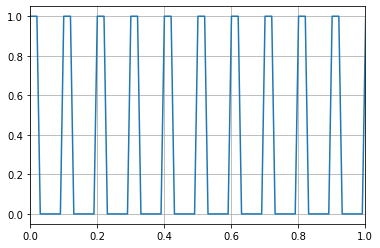

In [3]:
# При слишком большом frame_skip график начинает отображаться с искажениями. Потому сначала мы смотрим на график.
# По идее, в RL нас не должно это волновать, ведь там мы напрямую передаём управляющий сигнал (1 - сила 1 Н, 0 - сила 0 Н)

env = CapsubotEnv()
n_periods = 50
max_period = 0.1
T_max = n_periods*max_period
#steps = int(T_max/env.min_period*10) # new model (какой-то бред. НЕ стоит на это смотреть)
#steps = int(T_max/env.dt)             # old model
steps = int(T_max/env.dt/env.frame_skip)       # end.dt / enf.frame_skip
ts = np.linspace(0, T_max, steps)

actions = []

for t in ts:
    action = F_step(t, T = 0.1, tau = 0.3)  # Should move with average velocity
    actions.append(action)
    
plt.plot(ts, actions)
plt.xlim(0, 1)
plt.grid(True)

In [ ]:
#int(T_max/env.min_period*10)
int(T_max/env.dt/40)

In [ ]:
import numpy as np
obs_norm = np.interp([-0.002, 0.0000075, 0.15], [-0.01, 0.2], [-1, 1])
obs_norm

In [ ]:
obs_norm = np.interp([-7.48286291e-02, -4.75411857e-07], [-1.151090712002199, 1.183106595060463], [-1, 1])
obs_norm

In [9]:
env = CapsubotEnv()
n_periods = 400
max_period = 0.1
T_max = n_periods*max_period
#steps = int(T_max/env.min_period*10) # Was T_max/env.dt #FIX IT!!!!!!!!!!!!!!!!!!! (for new model steps = int(T_max/env.min_period*10))
#steps = int(T_max/env.dt)             # old model
steps = int(T_max/env.dt/env.frame_skip)             # use this model like NEW
ts = np.linspace(0, T_max, steps)

states = []
actions = []
rewards = []
observ_list = []
av_speed_list = []
obs = env.reset()
for t in ts:
    states.append(env.state)
    action = F_step(t, T = 0.1, tau = 0.3)  # Should move with average velocity (Просто PWM)
    actions.append(action)
    obs, reward, done, info = env.step(action)
    observ_list.append(obs)
    av_speed_list.append(info.get('average_speed'))
    #print(f"env_state {env.state}")
    #print(f"obs {obs}")
    if done:
        print(f"DONE! x is {env.state[0]} total_tme {env.total_time}. Step Num = {env.step_counter}")
    rewards.append(reward)
    #if (t % 0.005 <= env.dt):
    env.render()
env.close()

C:\Users\Mi\anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


DONE! x is 0.30039544883459146 total_tme 24.670000000257193. Step Num = 2467
DONE! x is 0.3001531673875701 total_tme 24.680000000257525. Step Num = 2468
DONE! x is 0.2989656627220888 total_tme 24.690000000257857. Step Num = 2469
DONE! x is 0.29695175378003685 total_tme 24.70000000025819. Step Num = 2470
DONE! x is 0.2947440094551667 total_tme 24.71000000025852. Step Num = 2471
DONE! x is 0.29351441911096615 total_tme 24.720000000258853. Step Num = 2472
DONE! x is 0.2936205870028483 total_tme 24.730000000259185. Step Num = 2473
DONE! x is 0.29477654257820834 total_tme 24.740000000259517. Step Num = 2474
DONE! x is 0.2973036971046403 total_tme 24.75000000025985. Step Num = 2475
DONE! x is 0.30013685265425694 total_tme 24.76000000026018. Step Num = 2476
DONE! x is 0.30161543124395934 total_tme 24.770000000260513. Step Num = 2477
DONE! x is 0.3013666942273937 total_tme 24.780000000260845. Step Num = 2478
DONE! x is 0.3001704482839948 total_tme 24.790000000261177. Step Num = 2479
DONE! x is

### Тестим энвайронмент с хардкод весрией ступенчатой силы

In [5]:
states = np.array(states)
print(f"shape of states vector: {states.shape}")
print(f"length of actions vector: {len(actions)}")
print("---------------------------")
print(f"last 10 x pos from the states list: {states[-10:, 0]}")
print("---------------------------")
print(f"rewards: {rewards[100:110]}")
print("---------------------------")
print(f"max reward in list: {np.amax(rewards)}")
print(f"min reward in list: {np.amin(rewards)}")
print("---------------------------")
print(f"reward summ: {np.sum(rewards)}")
print("---------------------------")
print(f"10 last av_speed elements: {av_speed_list[-10:]}")

shape of states vector: (500, 4)
length of actions vector: 500
---------------------------
last 10 x pos from the states list: [0.06287103 0.06065848 0.0594237  0.05952759 0.06068299 0.06321093
 0.06604548 0.06752507 0.06727615 0.06607823]
---------------------------
rewards: [-2.389969750661627, -1.4406517607117082, -0.04416995757001475, 0.9685958592330953, 2.2772340017068045, 2.5622248412741944, 1.2875059737569097, -0.39191722448184835, -1.2600922400115357, -2.0047591204815225]
---------------------------
max reward in list: 7.704378552861692
min reward in list: -5.615114883932861
---------------------------
reward summ: 12.812444729785023
---------------------------
10 last av_speed elements: [0.012356106301975305, 0.012078208799108443, 0.012074179717808851, 0.012282048949889263, 0.012766923943356415, 0.013313151036035234, 0.01358627411320193, 0.013509934083722683, 0.013243840797019063, 0.01281244472978502]


In [6]:
print(np.amax(states[:, 0]), "\n")
print(np.amin(states[:, 0]))

0.0675324533158895 

-0.00043834639437245244


In [ ]:
print(states[:,])

In [ ]:
# Смотрю границы, в которых изменяются элемента observaion, чтобы применить к ним нормалиацию

for i in range(states.shape[1]):
    print(f"max: {np.amax(states[:, i])}")
    print(f"min: {np.amin(states[:, i])}")
    print("--------------------------------------------------------")

In [ ]:
# Тестирую пример нормализации

for i in states[2300:2400, 0]:
    print(f"i is {i}")
    obs_norm = np.interp([i], [-0.0007666844383611218, 0.07919885629789096], [-1, 1])
    print(obs_norm)

In [ ]:
def normilize_state(state: list) -> np.ndarray:
    norm_state = [None, None, None, None]
    norm_state[0] = np.interp(state[0], [-0.0007666844383611218, 0.07919885629789096], [-1, 1])
    norm_state[1] = np.interp(state[1], [-0.18283166534706963, 0.24274101317295704], [-1, 1])
    norm_state[2] = np.interp(state[2], [-0.01652187660136813, 0.019895362341591866], [-1, 1])
    norm_state[3] = np.interp(state[3], [-1.1832780931204638, 1.1508305412787394], [-1, 1])
        
    return np.array(norm_state)

In [ ]:
def normilize_state(state: list) -> np.ndarray:
    norm_state = []
    norm_state.append(np.interp(state[0], [-0.0007666844383611218, 0.07919885629789096], [-1, 1]))
    norm_state.append(np.interp(state[1], [-0.18283166534706963, 0.24274101317295704], [-1, 1]))
    norm_state.append(np.interp(state[2], [-0.01652187660136813, 0.019895362341591866], [-1, 1]))
    norm_state.append(np.interp(state[3], [-1.1832780931204638, 1.1508305412787394], [-1, 1]))
        
    return np.array(norm_state)

In [ ]:
norm_state = normilize_state(states[20])
norm_state

## На чём я остановился.
 - Результаты, которые я считал "хорошими", оказались наоборот плохохими. Я вместо min_period оставил dt случайно. Таким образом вместо просто 100к таймстепов я получил ещё и по 200 расчётов на каждом из 100к таймстепов.

## Params before i made some changes

In [ ]:
# states vector acter changing the env code
states_before_change = np.copy(states)

In [ ]:
states_before_change[:, 0]

In [ ]:
print(np.amax(states_before_change[:, 0]))
print(np.amin(states_before_change[:, 0]))

In [ ]:
rewards = np.array(rewards)
rewards_before = np.copy(rewards)
rewards_before.sum()

In [ ]:
actions = np.array(actions)
len(actions)

## Params after i made some changes

In [ ]:
states = np.array(states)
states.shape
states[:, 0]

In [ ]:
print(np.amax(states[:, 0]))
print(np.amin(states[:, 0]))

In [ ]:
rewards = np.array(rewards)
rewards.sum()

In [ ]:
actions = np.array(actions)
len(actions)

In [1]:
import os
import datetime

models_dir = os.path.join(
    "RL_WIP", "RL_data_store", "models", "PPO-"
) + datetime.datetime.now().strftime("%d_%m_%Y-%H_%M")

In [4]:
models_dir

'RL_WIP\\RL_data_store\\models\\PPO-07_09_2022-23_32'

In [5]:
os.path.join(models_dir, "asd")

'RL_WIP\\RL_data_store\\models\\PPO-07_09_2022-23_32\\asd'

In [6]:
TIMESTEPS = 1e5
i = 10

In [8]:
f"{int(TIMESTEPS * i)}"

'1000000'

In [9]:
os.path.join(models_dir, f"{int(TIMESTEPS * i)}")

'RL_WIP\\RL_data_store\\models\\PPO-07_09_2022-23_32\\1000000'

In [5]:
steps_in_period = 200
min_period = 0.01
dt = min_period / steps_in_period  # Action force discritization.
frame_skip = steps_in_period
print(dt)
print(frame_skip)

5e-05
200
